#  Question 6

Upload packages :

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
import seaborn as sns
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import gaussian_filter 
from scipy.interpolate import griddata
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [4]:
from ift6758.visualizations.complex_visualizations import selectDataFrameForPlotly, teamList, shotsCoordinatedCorrection,selectDataFrame, leagueAverageShotRatePerTeam, leagueAverageShotRatePerHour, dataframesCombination

# Question 6-1  :

Ensure you can work with the event coordinates correctly. This includes ensuring the shots are on the correct side of the rink (due to period changes, or start on different sides during a game), as well as being able to map from physical coordinates to pixel coordinates on the figure.


transforming our coordinates :

In [5]:
df = shotsCoordinatedCorrection('./2021finalDataset.csv')

In [6]:
df.head()

,gameID,eventType,period,periodTime,periodType,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide,x_bin,y_bin
0,2021020001,Shot,1,01:03,REGULAR,Tampa Bay Lightning,home,61.0,-32.0,Steven Stamkos,Tristan Jarry,Wrist Shot,NaN,NaN,2021,left,61.0,-32.0
1,2021020001,Shot,1,01:44,REGULAR,Pittsburgh Penguins,away,-65.0,19.0,Brock McGinn,Andrei Vasilevskiy,Wrist Shot,NaN,NaN,2021,right,65.0,-19.0
2,2021020001,Shot,1,02:01,REGULAR,Tampa Bay Lightning,home,-8.0,-27.0,Jan Rutta,Tristan Jarry,Wrist Shot,NaN,NaN,2021,left,8.0,27.0
3,2021020001,Shot,1,02:47,REGULAR,Pittsburgh Penguins,away,-60.0,-4.0,Danton Heinen,Andrei Vasilevskiy,Wrist Shot,NaN,NaN,2021,right,60.0,4.0
4,2021020001,Shot,1,03:07,REGULAR,Tampa Bay Lightning,home,63.0,4.0,Ondrej Palat,Tristan Jarry,Wrist Shot,NaN,NaN,2021,left,63.0,4.0


# Question 6-2 :
Compute aggregate statistics of shot locations across the entire league to compute league average shot rate per hour. You can make a few simplifying assumptions:
You can assume all shots are even strength; this means you can simply aggregate over all shots rather than having to figure out whether a shot was an even strength shot or not.


In [7]:
df2 =leagueAverageShotRatePerHour(df)

In [8]:
df2.head()

,x_bin,y_bin,totalShoots,avgShotsPerHour
0,0.0,-41.0,1,0.000740
1,0.0,-40.0,1,0.000740
2,0.0,-39.0,1,0.000740
3,0.0,-38.0,2,0.001479
4,0.0,-37.0,2,0.001479


# Question 6-3 :
Group shots by team, and use the league average shot rate per hour computed above to compute the excess shot rate per hour. You can choose to represent this as either a raw difference in goals between the teams, or a percentage.

In [9]:
df_3 = leagueAverageShotRatePerTeam(df,'Anaheim Ducks' )

In [10]:
df_3.head()

,x_bin,y_bin,totalShotsPerTeam
0,0.0,-41.0,1
1,0.0,10.0,1
2,0.0,31.0,1
3,0.0,39.0,1
4,1.0,-32.0,1


# Question 6-4 :
Make appropriate choices to bin your data when displaying it. You could also consider using smoothing techniques to make your shot maps more readable. A common strategy is to use kernel density estimation with a Gaussian kernel.

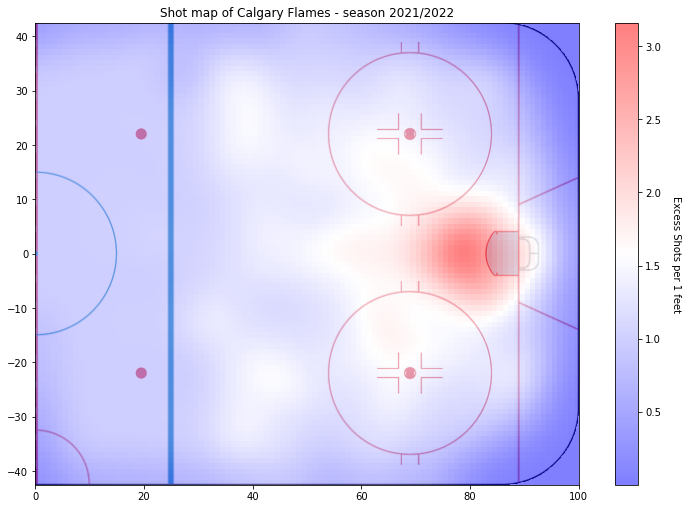

In [11]:
def plotShotMap(season_year, team, df):
    fig, ax = plt.subplots(figsize=(13,8.5),facecolor='w', edgecolor='k')
            
    season_games = dataframesCombination(df,team )
    img = plt.imread('../figures/nhl_rink.png')

    ext = [-100, 100, -42.5, 42.5]
    plt.imshow(img, zorder=0, extent=ext, aspect=1)
    # Generate some test data
    [x,y] = np.round(np.meshgrid(np.linspace(0,100,100),np.linspace(-42.5,42.5,85)))
    excessShotRate = griddata((season_games['x_bin'],season_games['y_bin']),season_games['excessShotRate'],(x,y),method='cubic',fill_value=0)
    excessShotRate = np.where(excessShotRate < 0,0,excessShotRate)
    
    
    img = gaussian_filter(excessShotRate, sigma=4)
    img = ax.imshow(img, extent=[0, 100, -42.5, 42.5], origin='lower', cmap='bwr', alpha=0.5 )#, clim=(-1, 1))
    
    cbar = plt.colorbar(img, ax=ax, pad = 0.05)
    cbar.ax.set_ylabel('Excess Shots per 1 feet', rotation=270, labelpad=20)
    ax.set_title(f"Shot map of {team} - season {season_year}/{season_year+1}")
    
    plt.show()
    
plotShotMap(2021, 'Calgary Flames' ,df )

# Question 5 : 
Make the plot interactive with options to select the team. The easiest way to do this is using something like plotly or bokeh

In [12]:
@interact(
    season_year=widgets.IntSlider(min=2016, max=2021, step=1),
)
def show_data(season_year):
    season_games = selectDataFrame(season_year)
    
    @interact(
    team=teamList(season_year))
    def data(team) : 
        print('Number of teams :' , len(team))
        plotShotMap(season_year, team, season_games)
        display(season_games.head())
        


interactive(children=(IntSlider(value=2016, description='season_year', max=2021, min=2016), Output()), _dom_cl…